# Image Interpretation – Assignment 6

This assignment on __Unsupervised Learning__ covers the labs from the 28th of November and 5th of December and is graded by a maximum of $15$ points.

In order to submit the results, send a ZIP file with your implemented code to <riccardo.delutio@geod.baug.ethz.ch> with subject [Image Interpretation 2016 Assignment 6] no later than on the 12th of December, 2019.

Your functions should work when called by the provided test code (functions prefixed with `test_`) which __must not__ be modified. When run, they should produce a plausible output, no warnings, and no unnecessary output (remember to end your statements with semicolons). In
order to help you verify whether or not your code is doing what it is supposed to, reference images `ref_`-images that show example output for each test script come with the provided code. (This were made with the matlab version of the code).

In addition to the functions, include a report (__max. 8 pages__ PDF) explaining the structure of the code and the python/Matlab functions used. This includes the reasons for choosing particular functions as well as a short justification of their parameter setting. For the more complicated tasks, the choice of the underlying data structures and algorithms should be explained too. We encourage you to add also diagrams, illustrations, and figures into the report when appropriate, but it is not necessary to copy the related theory from the lecture slides. The report should not contain any code snippets (but the code should contain comments if appropriate).

__Team work is not allowed__. Everybody implements his/her own code and writes his/her own report. Discussing issues with others is fine, sharing code and/or report with others is __not__. If you use any code fragments found on the Internet, make sure you reference them properly. 

As opposed to the last assignment this one does not rely on built-in functions. You are asked to implement all functions from scratch completely on your own. This is done for two reasons: (i) k-means and mean shift are two very important techniques in pattern recognition that
anyone taking such a course should have implemented once to fully understand them and (ii) implementing them is feasible and straightforward. All equations that have to be implemented are given and each task description takes you step-by-step through the code.

k-means (exercise 1) and mean shift (exercise 3) should both be run with both given test scripts. Inside the first test script the simulated data stays fixed for each trial whereas a new random sample is drawn if running the second test script more than once. This is to show you what impact different parameter settings have (the first test script) and what impact different data distributions/patterns have if parameters remain fixed (the second test script).


# Exercise 1, 5 pts

The k-means clustering is a standard approach for clustering data. Due to its simplicity it is a common tool in practice today. Implement the k-means algorithm in a function called `ii_kmeans` that should take 3 arguments:

1.  input data: sample points in a N-by-2 matrix (number of rows is the number of samples, dimensionality of the input data will always be 2 for this exercise)

2.  the number of clusters K, a scalar

3.  the number of iterations, a scalar

It should return two values.

1.  cluster indexes: a column vector with N rows, specifying the cluster index for each sample

2.  cluster centers: a K-by-2 matrix, returning the cluster centers for each cluster

First, initialize the cluster centers by choosing K distinct points randomly from the input data. The Numpy function `random.choice` can be useful here (be careful to sample without replacement). The next two steps are then repeated until the cluster assignments do not change any more or the number of iterations is reached (whichever comes first). 

In the __assignment step__, determine the closest cluster center for each point and store its index in a vector of indexes. If no index changed during the assignment step, stop the iteration. In the __update step__, replace each cluster center with the mean of the points in the respective cluster. Note that it can happen that a cluster ends up without any points. In this case, you cannot compute the mean and should thus pick a random point from the input data and use its position as the new cluster center. After both steps (the __assignment step__ and the __update step__), call the function `visualize_kmeans` which takes 4 arguments: input data, the vector of cluster indexes, cluster centers, and a scalar (set it to `false` for the call after the assignment step and to `true` for the call after the update step). This helps visualize what the algorithm is doing, note that you don't have to do this at all iterations. Once running a test script push enter to proceed to the next step.

__Report__: Run your code with the first test script `test_kmeans1` (fixed data sample) and evaluate several different parameter settings. Next, run your code with the second test script `test_kmeans2` (newly random data sample per run) and keep parameters fixed for several runs. Then repeat with a different parameter setting and so on. Discuss all differences and results (and their theoretical reasons) in the report. Also think about what may cause k-means to fail (or at least underperform) and how one might reduce the risk of it happening.

In [6]:
# Some imports you need for the exercises
import numpy as np 
import matplotlib.pyplot as plt    
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import clear_output
%matplotlib inline
from scipy.stats import norm, multivariate_normal
from scipy.special import gamma

import random
import math

In [7]:
# DONT MODIFY
def visualize_kmeans(data,idx,centers,updated=None):
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(1,1,1)
    ax.scatter(data[:,0],data[:,1],marker='.', c=idx)
    ax.plot(centers[:,0],centers[:,1],'+',color='r',markersize=15,mew=2)
    if updated is not None:
        if updated:
            ax.set_title('After update step')
        else:
            ax.set_title('After assignment step')
    plt.show()
    input('Press Enter to pass')
    plt.close()
    clear_output()

In [8]:
def ii_kmeans(data,n_centers,n_iterations):
    # YOUR CODE HERE 
    
    # Initialization
    centroids = inti_centroids(data,n_centers)
    last_idx = np.zeros(len(data)).tolist() 
    
    # Iteration
    for iter in range(n_iterations):
        # Assignment
        idx, clusters = assign_clusters(data,centroids)
        # visualize_kmeans(data,idx,np.array(centroids),updated=False)
        
        # Decide if clusters converge or not
        if last_idx==idx:
            print('K-Means converges at',iter,'th iteration')
            break
                
        if iter==n_iterations-1:
            print('Finish K-Means with',n_iterations,'iterations.')
    
        # Update
        centroids = calc_newcentroids(data,clusters)
        # visualize_kmeans(data,idx,np.array(centroids),updated=True)
        last_idx = idx
        
    return idx, centroids

In [9]:
def inti_centroids(data,n_centers):
    centroids = []
    
    for i in range(n_centers):
        rand = random.randint(0,len(data)-1) # randomize without replacement
        rand_val = tuple(data[rand,:])
        while rand_val in centroids:
            # Make sure no same points chosen twice for centers
            rand = np.random.randint(0,len(data)-1)
            rand_val = tuple(data[rand,:])
        else:
            centroids.append(rand_val)
    
    return centroids

In [10]:
def assign_clusters(data,centroids):
    idx = []
    clusters = {}
    
    for center in centroids:
        clusters[center] = []
    
    for i in range(len(data)):
        pnt_dists = {}
        for center in centroids:
            dist = math.sqrt(sum((np.array(data[i])-np.array(center))**2))
            pnt_dists[dist] = center
        # Find the closest center index and coordinates for each point
        center_coor = pnt_dists.get(min(pnt_dists))
        clusters[center_coor].append(i) # assign each cluster the point indexes
        idx.append(centroids.index(center_coor)) # assign the closest center index to each point

    return idx, clusters

In [11]:
def calc_newcentroids(data,clusters):
    newcentroids = []
    
    for old_centroid, membership in clusters.items():
        # Deal with case when no points are in the cluster
        if len(membership)==0:
            rand = random.randint(0,len(data)-1)
            newcentroids.append(tuple(data[rand,:]))
        else:
            newcentroids.append(tuple(np.mean(data[membership,:], axis=0)))
    
    return newcentroids

In [12]:
# DONT MODIFY
def test_kmeans1():
    data = np.genfromtxt('kmeans_example.csv', delimiter=',')
    idx, centers = ii_kmeans(data, 6, 100)
    print("K-Means done")

In [13]:
test_kmeans1()

K-Means done


In [41]:
# DONT MODIFY
def test_kmeans2():
    true_cn = np.random.randint(8,13)
    spread = 5*np.random.rand()+5
    means = np.random.randn(true_cn,2)*spread
    covariance = np.identity(2)
    data = np.ones((1000,2))
    for i in range(1000):
        choice = np.random.randint(true_cn)
        data[i,:] = np.random.multivariate_normal(means[choice,:],covariance)
    idx, centers = ii_kmeans(data, 6, 100)
    visualize_kmeans(data,idx,np.array(centers),updated=True)
    print("K-Means done")    

In [43]:
test_kmeans2()

K-Means done


# Exercise 2, 5 pts

Kernel density estimation is an essential part of many state-of-the-art pattern recognition methods like mean shift, for example. Write a function `ii_kde` that estimates kernel densities, which takes four input arguments:

1.  input data: sample points in a N-by-d matrix (number of rows is the number of samples, number of columns is the dimensionality of the feature space)

2.  kernel bandwidth: the scale (width, size) of the kernel, a scalar

3.  kernel type: which kernel to use, a string -- `’parzen’`, `’normal’`, or `’epanechnikov’`. Note that in order to structure your code well it might be helpful to write an own function per kernel type that is called inside `ii_kde`.

4.  query points: the points where the kernel density is to be estimated, a matrix (M is the number of query points)

The function should return a column vector with M rows, where the i-th value of the vector is the kernel density at the position specified by the i-th row of the query point matrix.

Instead of the formulas from the lecture slides, use the following formulas to compute the kernel density estimate per query point:

$$\begin{aligned}
\label{eq:parzen}
        KDE_\mathrm{Parzen}(\mathbf{q}) = \frac{1}{h^dN} \sum_{i=1}^{N}
        I\left(\|\mathbf{q}-\mathbf{x}_i\|_\infty \le
        \frac{h}{2}\right)
    \end{aligned}$$ 

where $\|\mathbf{v}\|_\infty$ is the infinity norm, equal to the largest absolute value of the vector components, *h* is the kernel bandwidth, $\mathbf{q}$ is the center of the kernel (the query points), $\mathbf{x}_i$ is the current data point in feature space, and *d* is the dimension of the feature space (e.g. 1 if run with test script `test_kde_1d`). $I(\cdot)$ is an indicator function, i.e. it is 1 if the argument is true and 0 otherwise. More precisely,
the sum in Eq. [\[eq:parzen\]](#eq:parzen) counts the number of input points that are located inside the kernel which is mathematically expressed via $\|\mathbf{q}-\mathbf{x}_i\|_\infty\le \frac{h}{2}$.

While the `parzen` function counts all points that fall into a kernel with equal weight 1, `normal` and `epanechnikov` kernels apply weights as a function of the distance from the kernel's center point $\mathbf{q}$:

$$\begin{aligned}
        KDE_\mathrm{Normal}(\mathbf{q}) = \frac{1}{h^dN}
        \frac{1}{(2\pi)^\frac{d}{2}} \sum_{i=1}^{N} \exp\left(-\frac12
        \frac{\|\mathbf{q}-\mathbf{x}_i\|^2}{h^2}\right)
    \end{aligned}$$

Here, $\|v\|$ is the usual 2-norm (or euclidean norm, i.e. the euclidean distance in feature space).

$$\begin{aligned}
        KDE_\mathrm{Epanechnikov}(\mathbf{q}) = \frac{1}{h^dN}
        \frac{d+2}{2V_d} \sum_{i=1}^{N} \max\left(0,1-\frac{\|\mathbf{q}-\mathbf{x}_i\|^2}{h^2}\right)
    \end{aligned}$$ 

where $V_d$ is the volume of the d-dimensional unit sphere (a sphere with radius 1). 

$$\begin{aligned}
        V_d = \frac{\pi^\frac{d}{2}}{\Gamma(\frac{d}{2}+1)}
    \end{aligned}$$ 
    
$\Gamma(\cdot)$ is the gamma function. It can be computed in python with the function `gamma` from the Scipy library. The purpose of the $\max$ is to replace negative values with 0.

__Report__: In order to verify if your kernels are implemented correctly you may want to start with test script `test_kde_1d_onepoint`, which returns the kernel shapes (check against `ref_test_kde_1d_onepoint.png` or images on the corresponding lecture slide). Next, run `test_kde_1d` and `test_kde_2d` to compare outcomes of the different kernels for varying bandwidths in your report. Last, run `test_kde_1d_fewsamples`, which has data gaps. Again, compare all results in your report and explain reasons for performance differences (between kernels, bandwidths, and compared to complete data samples of `test_kde_1d`) based on the theory.

In [14]:
def ii_kde(data,h,kernel_type,query_points):
    # YOUR CODE HERE
    
    # Decide the number and dimension of input data 
    if isinstance(data,float) or isinstance(data,int):
        n,d = 1,1
    else:
        n,d = data.shape
    
    # Decide the kernel type
    if kernel_type == 'parzen':
        value = ii_parzen(data,h,query_points,n,d)
    elif kernel_type == 'normal':
        value = ii_normal(data,h,query_points,n,d)
    elif kernel_type == 'epanechnikov':
        value = ii_epanech(data,h,query_points,n,d)
    else:
        print('Please input kernel type among \'parzen\',\'normal\',\'epanechnikov\'!')
    
    return value

In [15]:
def ii_parzen(data,h,query_points,n,d):
    value = np.zeros(query_points.shape[0])
    
    for i in range(query_points.shape[0]):
        if n==1:
            diff = np.max(abs(query_points[i]-data))
        else:
            diff = np.max(abs(query_points[i]-data),axis=1)
        indicator = diff<=h/2
        value[i] = 1/(np.power(h,d)*n) * np.sum(indicator==1)
        
    return value

In [16]:
def ii_normal(data,h,query_points,n,d):
    value = np.zeros(query_points.shape[0])
    
    for i in range(query_points.shape[0]):
        if n==1:
            normsqr = np.linalg.norm((query_points[i]-data))**2
        else:
            normsqr = np.linalg.norm((query_points[i]-data),axis=1)**2
        exponent = np.exp(-normsqr/(2*np.power(h,2)))
        value[i] = 1/(np.power(h,d)*n) * 1/np.power(2*math.pi,d/2) * np.sum(exponent)
        
    return value

In [17]:
def ii_epanech(data,h,query_points,n,d):
    value = np.zeros(query_points.shape[0])
    
    for i in range(query_points.shape[0]):
        if n==1:
            normsqr = np.linalg.norm((query_points[i]-data))**2
        else:
            normsqr = np.linalg.norm((query_points[i]-data),axis=1)**2
        normmax = 1-normsqr/(h**2)
        indicator = normmax>0
        vd = np.power(math.pi,d/2)/gamma(d/2+1)
        value[i] = 1/(np.power(h,d)*n) * (d+2)/(2*vd) * np.sum(normmax[indicator==1])
        
    return value

In [18]:
# DONT MODIFY
def visualize_kde(data,sample_points,h,true_pdf=None):
    value = ii_kde(data,h,'parzen',sample_points)
    plt.plot(sample_points, value, 'r-', label = 'Parzen')
    value = ii_kde(data,h,'normal',sample_points)
    plt.plot(sample_points, value, 'b-', label = 'Normal')
    value = ii_kde(data,h,'epanechnikov',sample_points)
    plt.plot(sample_points, value, 'g-', label = 'Epanechnikov')
    
    if true_pdf is not None:    
        plt.plot(sample_points,true_pdf(sample_points),'k--',label = 'True')
    
    plt.title('Bandwith %s'%h)
    plt.legend(loc=4)

In [19]:
# DONT MODIFY
def test_kde_1d_onepoint():
    np.random.seed(42)
    data = 0.
    sample_points = np.arange(-3,3.05,0.05)
    
    fig = plt.figure(figsize=(14,10))
    
    fig.add_subplot(2,2,1)
    visualize_kde(data,sample_points,1)
    
    fig.add_subplot(2,2,2)
    visualize_kde(data,sample_points,2)

    fig.add_subplot(2,2,3)
    visualize_kde(data,sample_points,0.5)
    
    fig.add_subplot(2,2,4)
    plt.hist(data,30,density=True)
    plt.title('Histogram')


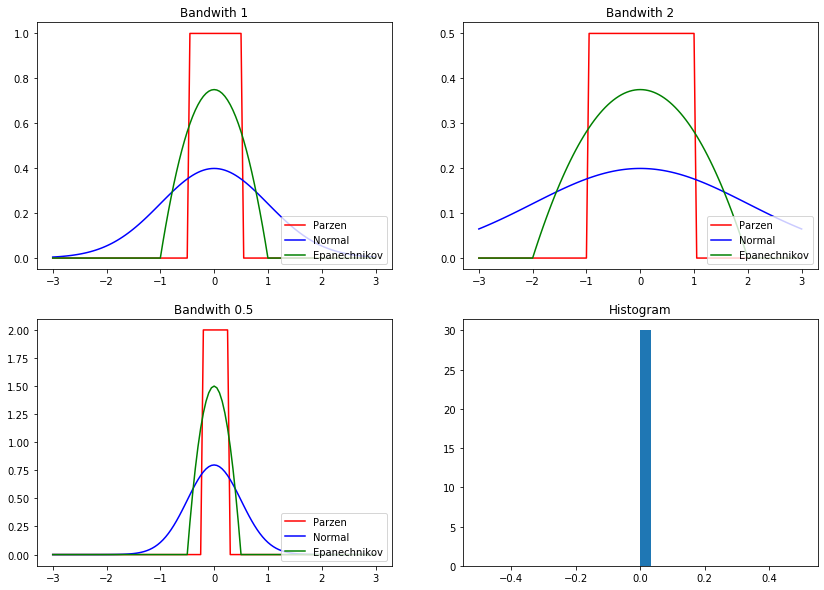

In [20]:
test_kde_1d_onepoint()

In [51]:
# DONT MODIFY
def test_kde_1d():
    np.random.seed(42)
    data = np.concatenate((np.random.randn(2000,1)-2.,np.random.randn(1500,1)+2.))
    sample_points = np.arange(-5,5.05,0.05)
    def true_pdf(data):
        rv1 = norm(-2)
        rv2 = norm(2)
        return (4./7.)*rv1.pdf(data) + (3./7.)*rv2.pdf(data)
    
    fig = plt.figure(figsize=(14,10))
    
    fig.add_subplot(2,2,1)
    visualize_kde(data,sample_points,1,true_pdf)
    
    fig.add_subplot(2,2,2)
    visualize_kde(data,sample_points,2,true_pdf)

    fig.add_subplot(2,2,3)
    visualize_kde(data,sample_points,0.5,true_pdf)
    
    fig.add_subplot(2,2,4)
    plt.hist(data,30,density=True)
    plt.title('Histogram')
    

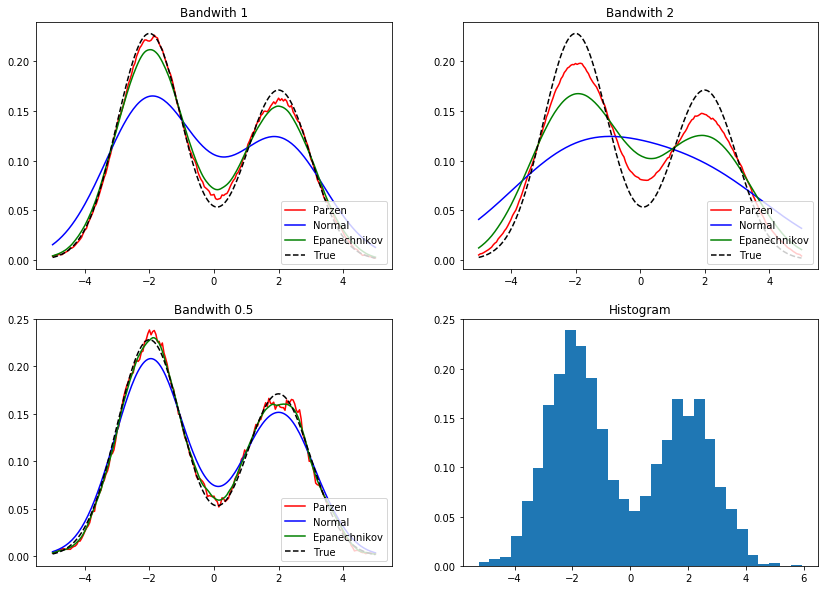

In [52]:
test_kde_1d()

In [62]:
# DONT MODIFY
def visualize_kde_2d(data,sample_points_x,sample_points_y,true):
    grid_x, grid_y = np.meshgrid(sample_points_x,sample_points_y)
    sample_points = np.hstack((grid_x.reshape((-1,1)),grid_y.reshape((-1,1))))
    
    h = 2.2
    values = ii_kde(data,h,'parzen', sample_points)
    fig = plt.figure(figsize=(14,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X=grid_x,Y=grid_y,Z=values.reshape(grid_x.shape))
    plt.title('Parzen (h=%s)'%h)
    plt.show()    
    
    h = 1.2
    values = ii_kde(data,h,'epanechnikov', sample_points)
    fig = plt.figure(figsize=(14,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X=grid_x,Y=grid_y,Z=values.reshape(grid_x.shape))
    plt.title('Epanechnikov (h=%s)'%h)
    plt.show()
    
    h = 0.7
    values = ii_kde(data,h,'normal', sample_points)
    fig = plt.figure(figsize=(14,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X=grid_x,Y=grid_y,Z=values.reshape(grid_x.shape))
    plt.title('Normal (h=%s)'%h)
    plt.show()
    
    values = true(sample_points)
    fig = plt.figure(figsize=(14,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X=grid_x,Y=grid_y,Z=values.reshape(grid_x.shape))
    plt.title('True Distribution')
    plt.show()

In [63]:
# DONT MODIFY
def test_kde_2d():
    np.random.seed(42)
    true_cn = np.random.randint(8,13)
    spread = 5*np.random.rand()+1
    means = np.random.randn(true_cn,2)*spread
    selection_prior = np.random.rand(true_cn)+0.2
    selection_prior /= np.sum(selection_prior)
    covariance = np.identity(2)
    data_size = 100
    data = np.ones((data_size,2))
    for i in range(data_size):
        choice = np.random.choice(range(true_cn),p=selection_prior)
        data[i,:] = np.random.multivariate_normal(means[choice,:],covariance)
    maxv = np.max(data,0)
    minv = np.min(data,0)
    steps = 100
    xrange = np.linspace(minv[0],maxv[0],steps)
    yrange = np.linspace(minv[1],maxv[1],steps)

    class true_pdf:
        def __init__(self,selection_prior,means,covariance=np.identity(2)):
            self.selection_prior = selection_prior
            self.means = means
            self.covariance = covariance
        def __call__(self,data):
            pdf = 0.
            for i, sel in enumerate(self.selection_prior):
                pdf += sel * multivariate_normal(self.means[i,:],self.covariance).pdf(data)
            return pdf
        
    visualize_kde_2d(data,xrange,yrange,true_pdf(selection_prior=selection_prior,means=means))

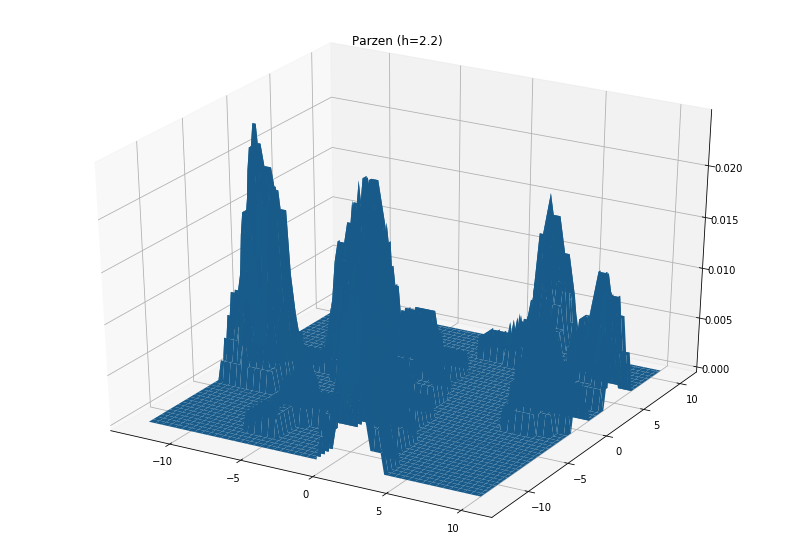

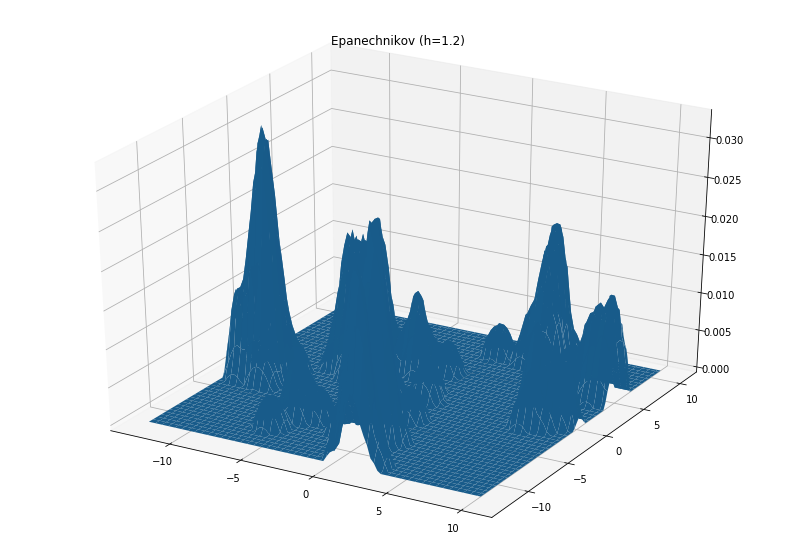

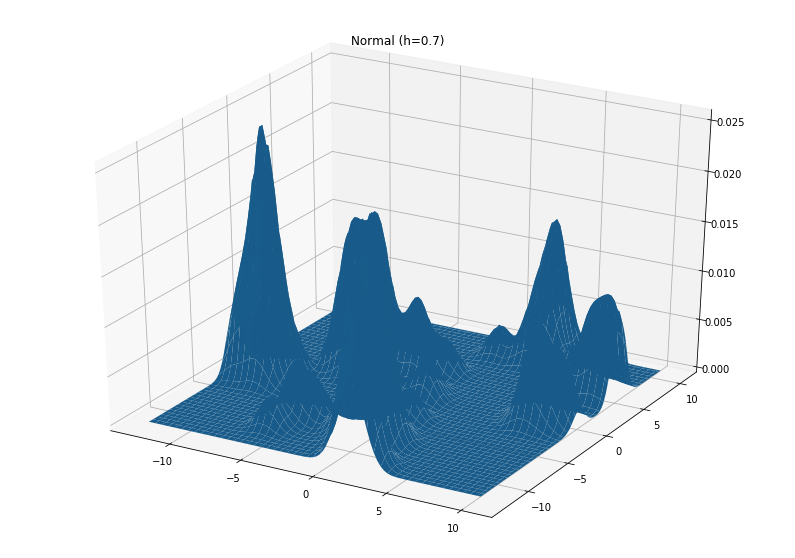

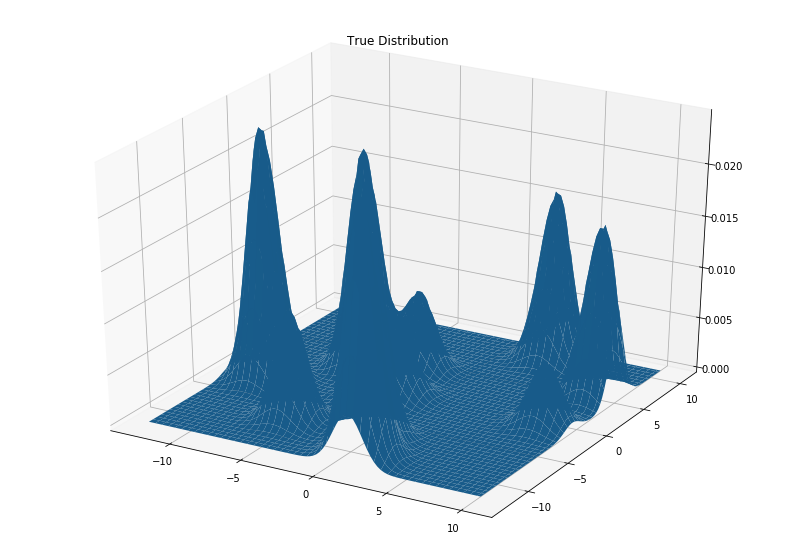

In [64]:
test_kde_2d() # You can double click on the figures to expand them 

In [65]:
# DONT MODIFY
def test_kde_1d_fewsamples():
    np.random.seed(42)
    data = np.concatenate((np.random.randn(40,1)-2.,np.random.randn(30,1)+2.))
    sample_points = np.arange(-5,5.05,0.05)
    def true_pdf(data):
        rv1 = norm(-2)
        rv2 = norm(2)
        return (4./7.)*rv1.pdf(data) + (3./7.)*rv2.pdf(data)
    
    fig = plt.figure(figsize=(14,10))
    
    fig.add_subplot(2,2,1)
    visualize_kde(data,sample_points,1,true_pdf)
    
    fig.add_subplot(2,2,2)
    visualize_kde(data,sample_points,2,true_pdf)

    fig.add_subplot(2,2,3)
    visualize_kde(data,sample_points,0.5,true_pdf)
    
    fig.add_subplot(2,2,4)
    plt.hist(data,30,density=True)
    plt.title('Histogram')

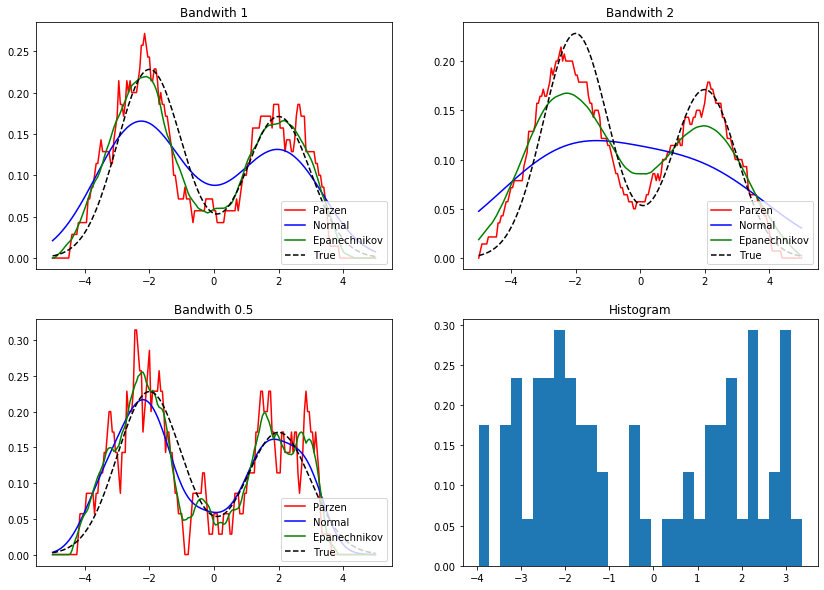

In [66]:
test_kde_1d_fewsamples()

# Exercise 3, 5 pts

Write a function `ii_meanshift` that performs the mean shift algorithm. The function takes 3 arguments:

1.  input data: sample points in a N-by-2 matrix (number of rows is the number of samples, dimensionality of the input data will always be 2 for this exercise)

2.  the kernel bandwidth $h$

3.  the stopping threshold $\vartheta$

It should return two values.

1.  cluster indexes: a column vector with N rows, specifying the cluster index for each sample

2.  cluster modes: a M-by-2 matrix, returning the cluster modes (the points with the highest density) for each cluster (where M is the number of clusters)

For this task, use the Epanechnikov kernel. Luckily all terms before the sum cancel out in the mean shift formula, leading to :

$$\begin{aligned}
        \mathbf{q}_{t+1} = \frac{
            \sum_{i=1}^N \mathbf{x}_i 
            \max\left(0, 1 - \frac{\|\mathbf{q}_t - \mathbf{x}_i\|^2}{h^2} \right)
        } {
            \sum_{i=1}^N 
            \max\left(0, 1 - \frac{\|\mathbf{q}_t - \mathbf{x}_i\|^2}{h^2} \right)
        }
    \end{aligned}$$

Start the mean shift procedure at each point and iterate until $\|\mathbf{q}_{t}-\mathbf{q}_{t-1}\| < \vartheta$ where $\vartheta$ is the threshold passed to the function. Alternatively, stop the iteration when $\frac{s_t}{s_{t-1}} < 10^{-6}$ where $s_t = \|\mathbf{q}_{t}-\mathbf{q}_{t-1}\|$ (which works slightly better and removes the need for the threshold $\theta$). When the iteration stopped, decide if a cluster mode already exists that is closer than $\frac{h}{5}$. If yes, assign the point that you started at to this
cluster. Otherwise, create a new cluster and assign the point to the new cluster. It can be helpful to visualize the steps you are taking during the mean shift procedure to spot errors.

__Report__: Evaluate your code with test scripts `test_meanshift1` and `test_meanshift2`. The first test script `test_meanshift1` uses exactly the same data as `test_kmeans1` for k-means. Compare results of k-means and mean shift and explain performance differences based on the theory behind both algorithms. Finally, run `test_meanshift2`, which samples data points randomly like `test_kmeans2` for k-means, and again compare both k-means's and mean shift's results in your report. Also try `test_meanshift2` multiple times for fixed mean shift parameter settings and report your findings.

In [37]:
def ii_meanshift(data,h,theta):
    # YOUR CODE HERE
    
    idx = []
    centroids = []
    
    for i in range(len(data)):
        # Initialization
        q = data[i]
        q_before = q-0.01 # initialize to not stop the first iteration
        
        while True: 
            # Assignment
            normsqr = np.linalg.norm((q-data),axis=1)**2
            normmax = 1-normsqr/(h**2)
            normmax[normmax<0] = 0
            q_update = np.sum((data.T*normmax).T,axis=0) / np.sum(normmax)

            # Decide if mean-shift converges at this point or not
            if np.linalg.norm(q_update-q)<theta or np.linalg.norm(q_update-q)/np.linalg.norm(q-q_before)<1e-6:
                break
                
            q_before = q
            q = q_update
        
        # Update
        flag = False
        for j in range(len(centroids)):
            if np.linalg.norm(q_update-centroids[j])<h/5:
                idx.append(j)
                flag = True
                break
        
        if flag!=True:
            centroids.append(q_update)
            idx.append(len(centroids)-1)
            
    centroids = np.array(centroids) # for visualization

    print('Mean-shift done')
    return idx, centroids

In [42]:
# DONT MODIFY
def test_meanshift1():
    data = np.genfromtxt('kmeans_example.csv', delimiter=',')
    idx, centers = ii_meanshift(data,5,0.001)
    visualize_kmeans(data=data,idx=idx,centers=centers)

In [64]:
test_meanshift1()

In [62]:
# DONT MODIFY
def test_meanshift2():
    true_cn = np.random.randint(8,13)
    spread = 5*np.random.rand()+1
    means = np.random.randn(true_cn,2)*spread
    covariance = np.identity(2)
    data_size = 800
    data = np.ones((data_size,2))
    for i in range(data_size):
        choice = np.random.randint(true_cn)
        data[i,:] = np.random.multivariate_normal(means[choice,:],covariance)
    idx, centers = ii_meanshift(data,5,0.001)
    visualize_kmeans(data=data,idx=idx,centers=centers)

In [63]:
test_meanshift2()